# 引入所需模块

In [1]:
import re
import json
import pandas as pd
import requests
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

## 读取数据（武汉2020年新冠疫情数据）

In [136]:
data = pd.read_csv("data.csv")
data

,date,感染者,疑似者,死亡,治愈,累积密切接触
0,2020/1/10,41,0,1,2,739
1,2020/1/11,41,0,1,6,763
2,2020/1/12,41,0,1,7,763
3,2020/1/13,41,0,1,7,763
4,2020/1/14,41,0,1,7,763
...,...,...,...,...,...,...
217,2020/8/15,84827,3,4634,79575,805857
218,2020/8/16,84849,4,4634,79603,806649
219,2020/8/17,84871,3,4634,79642,807383
220,2020/8/18,84888,2,4634,79685,808005


# 画出武汉2020年疫情数据

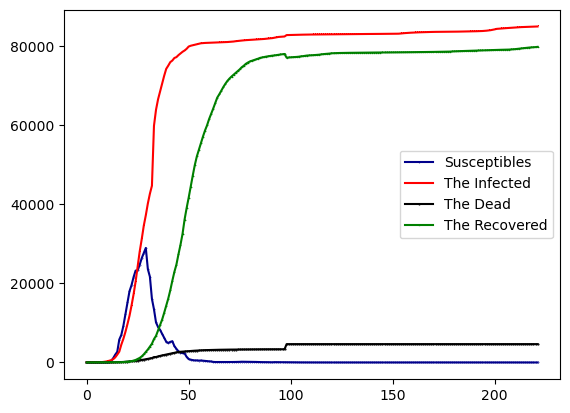

In [3]:
plt.plot(data.iloc[:,2],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
plt.plot(data.iloc[:,1],color = 'red',label = 'The Infected',marker = ',',markersize = 0.5)
plt.plot(data.iloc[:,3],color = 'black',label = 'The Dead',marker = 'o',markersize = 0.5)
plt.plot(data.iloc[:,4],color = 'green',label = 'The Recovered',marker = 'v',markersize = 0.5)
#plt.plot(data.iloc[:,4],color = 'yellow',label = 'The Exposed',marker = '^',markersize = 0.5, alpha = 0.5)
plt.legend()
plt.show()

In [4]:
now_infected = data.iloc[:, 1] - data.iloc[:, 4]

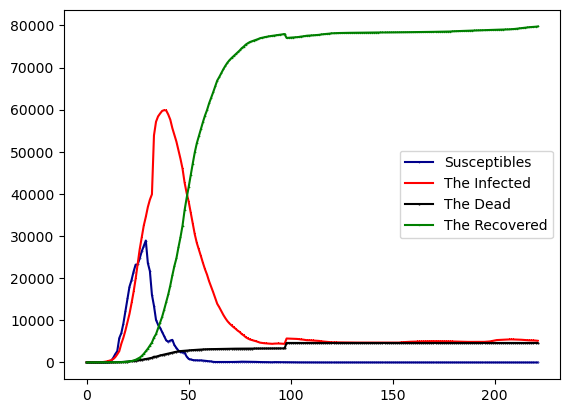

In [5]:
plt.plot(data.iloc[:,2],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
plt.plot(now_infected,color = 'red',label = 'The Infected',marker = ',',markersize = 0.5)
plt.plot(data.iloc[:,3],color = 'black',label = 'The Dead',marker = 'o',markersize = 0.5)
plt.plot(data.iloc[:,4],color = 'green',label = 'The Recovered',marker = 'v',markersize = 0.5)
#plt.plot(data.iloc[:,4],color = 'yellow',label = 'The Exposed',marker = '^',markersize = 0.5, alpha = 0.5)
plt.legend()
plt.show()

In [143]:
temp = data.iloc[:,4].copy()
for i in range(1, len(data.iloc[:,4])):
    temp[i] = data.iloc[i,4] - data.iloc[i - 1, 4]
expose = []
sum_ = 0
for i in range(len(temp) - 6):
    if i == 0:
        sum_ = sum(temp[i:i+7])
    else:
        sum_ = sum(temp[i:i+7]) - sum_
    expose.append(sum_)
for i in range(0, 6):
    expose.append(expose[-1])

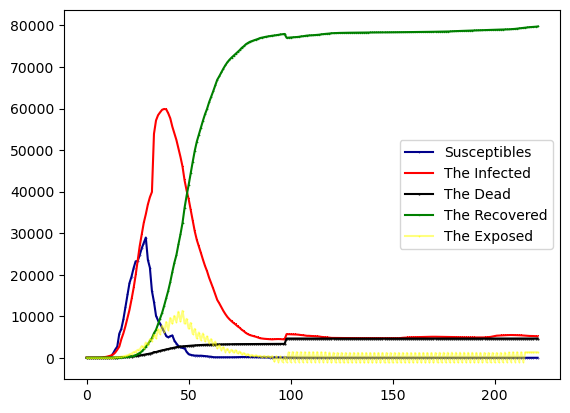

In [144]:
plt.plot(data.iloc[:,2],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
plt.plot(now_infected,color = 'red',label = 'The Infected',marker = ',',markersize = 0.5)
plt.plot(data.iloc[:,3],color = 'black',label = 'The Dead',marker = 'o',markersize = 0.5)
plt.plot(data.iloc[:,4],color = 'green',label = 'The Recovered',marker = 'v',markersize = 0.5)
plt.plot(expose,color = 'yellow',label = 'The Exposed',marker = '^',markersize = 0.5, alpha = 0.5)
plt.legend()
plt.show()

## SI-Model

> SI 模型非常简化，它说健康人一旦感染，就将终生具有传染性，典型的就是 HIV 或者是生化危机这样。

S: Susceptibles，易感者，可能被感染的健康人

I: The Infected，感染者，即患者

β: 病毒传染给健康者的概率

γ: 疾病治愈率（在 SI 模型中，疾病治愈为 0）

INI: 初始状态下易感者与感染者的比例



In [6]:
class SI(object):
    def __init__(self, beta=0.2586, T=230):
        self.beta = beta
        self.gamma = 0
        self.I = 1e-6
        self.S = 1 - self.I
        self.T = T
        self.INI = (self.S, self.I)
        self.T_range = np.arange(0, self.T + 1)
    
    def calculate(self, prop, _):
        Y = np.zeros(2)
        X = prop
        Y[0] = - self.beta * X[0] * X[1] + self.gamma * X[1] # 易感者
        Y[1] = self.beta * X[0] * X[1] - self.gamma * X[1] # 感染者
        return Y
    
    def plot(self):
        RES = spi.odeint(self.calculate, self.INI, self.T_range)
        plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
        plt.plot(RES[:,1],color = 'red',label = 'The Infected',marker = '.',markersize = 0.5)
        plt.title('SI Model')
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Proportion')
        plt.show()

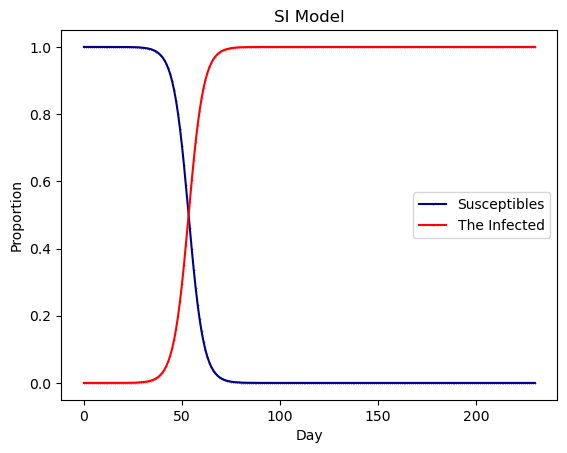

In [7]:
SI_ = SI()
SI_.plot()

## SIS-Model

> 有一些小病，感染者自己会恢复健康或者治好，典型的就是小感冒，人们会在 S 和 I 之间反复横跳。

S: Susceptibles，易感者，可能被感染的健康人

I: The Infected，感染者，即患者

β: 病毒传染给健康者的概率

γ: 疾病治愈率

INI: 初始状态下易感者与感染者的比例



In [8]:
class SIS(object):
    def __init__(self, beta=0.2586, gamma=0.018,T=150):
        self.beta = beta
        self.gamma = gamma
        self.I = 1e-6
        self.S = 1 - self.I
        self.T = T
        self.INI = (self.S, self.I)
        self.T_range = np.arange(0, self.T + 1)
    
    def calculate(self, prop, _):
        Y = np.zeros(2)
        X = prop
        Y[0] = - self.beta * X[0] * X[1] + self.gamma * X[1] # 易感者
        Y[1] = self.beta * X[0] * X[1] - self.gamma * X[1] # 感染者
        return Y
    
    def plot(self):
        RES = spi.odeint(self.calculate, self.INI, self.T_range)
        plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptible',marker = '.',markersize = 0.5)
        plt.plot(RES[:,1],color = 'red',label = 'The Infected',marker = '.',markersize = 0.5)
        plt.title('SIS Model')
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Proportion')
        plt.show()

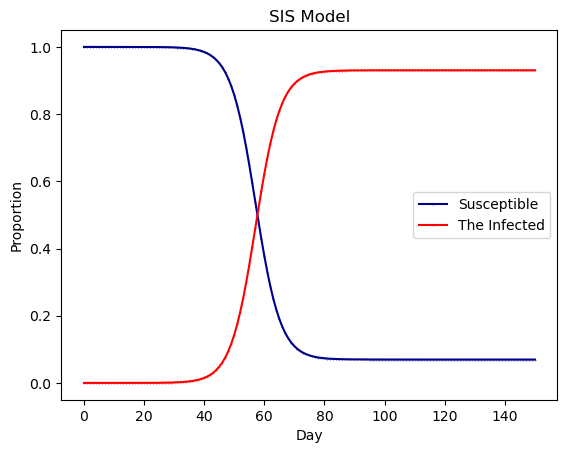

In [9]:
SIS_ = SIS()
SIS_.plot()

## SIR-Model

> 易感者会不断变为感染者，而感染者又会不断治愈变成康复者，并且不再被感染

S: Susceptibles，易感者，可能被感染的健康人

I: The Infected，感染者，即患者

R: The Recovered，康复者

β: 病毒传染给健康者的概率

γ: 疾病治愈率

INI: 初始状态下易感者、感染者与治愈者的比例


In [63]:
class SIR(object):
    def __init__(self, beta=0.3, gamma=0.018, T=220):
        self.beta = beta
        self.gamma = gamma
        self.I = 1e-6
        self.R = 1e-6
        self.S = 1 - self.I - self.R
        self.T = T
        self.INI = (self.S, self.I, self.R)
        self.T_range = np.arange(0, self.T + 1)

    
    def calculate(self, prop, T):
        Y = np.zeros(3)
        X = prop

        Y[0] = - self.beta * X[0] * X[1] # 易感者
        
        Y[1] = self.beta * X[0] * X[1] - self.gamma * X[1] # 感染者
        Y[2] = self.gamma * X[1] # 治愈者
        
        return Y
    


    
    def plot(self):
        
        RES = spi.odeint(self.calculate, self.INI, self.T_range)
        
        
        plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
        plt.plot(RES[:,1],color = 'red',label = 'The Infected',marker = '.',markersize = 0.5)
        plt.plot(RES[:,2],color = 'green',label = 'The Recovered',marker = '.',markersize = 0.5)
        plt.title('SIR Model')
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Proportion')
        plt.show()

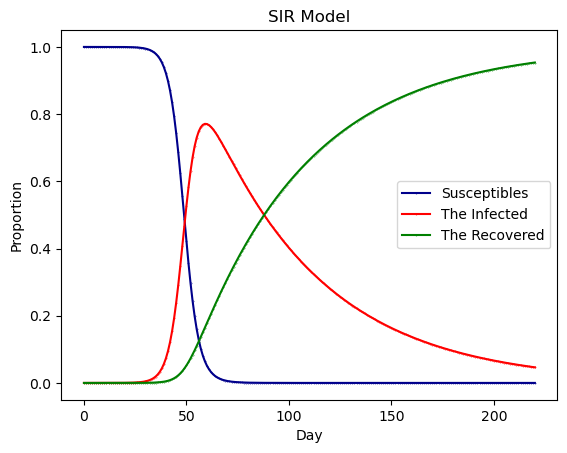

In [64]:
SIR_ = SIR()
SIR_.plot()

In [93]:

class SIR:
    def __init__(self, beta = 0.258, gamma = 0.018, T = 220):
        self.beta = beta
        self.gamma = gamma
        self.I = 1e-6
        self.R = 1e-6
        self.S = 1 - self.I - self.R
        self.T = T


    def update(self, T):
        if T >= 30:
            self.beta *= 0.999
            self.gamma *= 1.01

    def plot(self):
        S = [self.S]
        I = [self.I]
        R = [self.R]

        for _ in range(self.T):
            self.update(self.T)
            new_S = S[-1] - (self.beta * S[-1] * I[-1]) 
            new_I = I[-1] + (self.beta * S[-1] * I[-1])  - self.gamma * I[-1]
            new_R = R[-1] + self.gamma * I[-1]
            S.append(new_S)
            I.append(new_I)
            R.append(new_R)
        
        plt.plot(S, label='Susceptible')
        plt.plot(I, label='Infected')
        plt.plot(R, label='Recovered')
        plt.legend()
        plt.show()




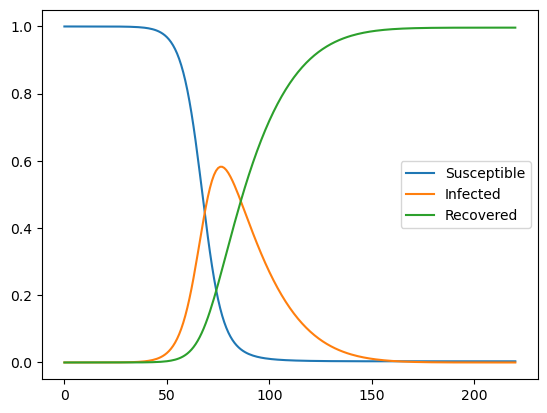

In [94]:
SIR_ = SIR()
SIR_.plot()

## SEIR-Model（考虑死亡率）

> 复杂的病毒，健康的人感染后会先经历潜伏期，一段时间之后才会出现症状。

S: Susceptibles，易感者，可能被感染的健康人

E: The Exposed，潜伏者

I: The Infected，感染者，即患者

R: The Recovered，康复者

D: The Dead，死亡者

β: 病毒传染给健康者的概率

γ1: 潜伏期治愈率（假设为 0）

γ2: 感染者治愈率

α: 潜伏者转换为感染者的比例（假设为 1）

INI: 初始状态下易感者、潜伏者、感染者、治愈者、死亡者的比例

θ: 死亡率


In [191]:
class SEIRD(object):
    def __init__(self, beta=0.2586, gamma_2=0.018, theta=0.002, T=220):
        self.beta = beta
        self.gamma_1 = 0.2
        self.gamma_2 = gamma_2
        self.alpha = 0.8
        self.theta = theta
        self.I = 0.6
        self.E = 0.1
        self.R = 0.1
        self.S = 1 - self.I - self.E - self.R
        self.D = 0
        self.T = T
        self.INI = (self.S, self.E, self.I, self.R, self.D)
        self.T_range = np.arange(0, self.T + 1)
    
    def calculate(self, prop, _):
        Y = np.zeros(5)
        X = prop
        Y[0] = - self.beta * X[0] * X[1] # 易感者
        Y[1] = self.alpha * X[2] - self.gamma_2 * X[1] - self.theta * X[1] # 感染者
        Y[2] = self.beta * X[0] * X[1] - (self.alpha + self.gamma_1) * X[2] # 潜伏者
        Y[3] = self.gamma_1 * X[2] + self.gamma_2 * X[1] # 治愈者
        Y[4] = self.theta * X[1] # 死亡者
        return Y
    
    def plot(self):
        RES = spi.odeint(self.calculate, self.INI, self.T_range)
        plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptibles',marker = '.',markersize = 0.5)
        plt.plot(RES[:,1],color = 'red',label = 'The Infected',marker = '.',markersize = 0.5)
        plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.',markersize = 0.5)
        plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.',markersize = 0.5)
        plt.plot(RES[:,4],color = 'black',label = 'The Dead',marker = '.',markersize = 0.5)
        plt.title('SEIRD')
        plt.legend()
        plt.xlabel('Day')
        plt.ylabel('Proportion')
        plt.show()

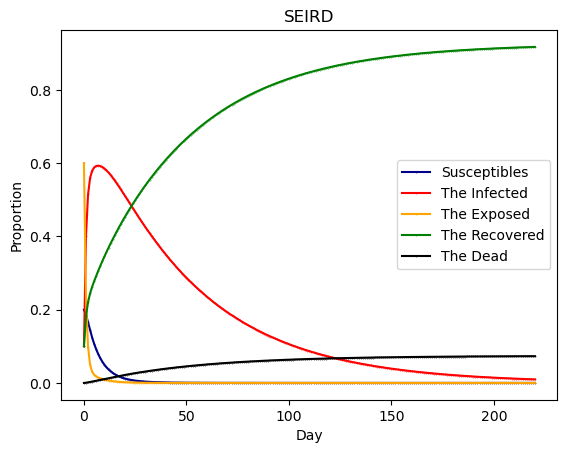

In [192]:
SEIRD_ = SEIRD()
SEIRD_.plot()

In [187]:

class SEIR:
    def __init__(self, beta = 0.2586, gamma = 0.018, sigma = 0.95, mu = 0.001, xi = 0.05, T=220):
        self.beta = beta
        self.gamma = gamma
        self.sigma = sigma
        self.mu = mu
        self.xi = xi
        self.I = 0.6
        self.E = 0.08
        self.R = 0.1
        self.S = 1 - self.I - self.E - self.R
        self.D = 0
        self.T = T

    def update(self):
        self.beta *= 0.999
        self.gamma *= 1.01

    def plot(self):
        S = [self.S]
        E = [self.E]
        I = [self.I]
        R = [self.R]
        D = [self.D]

        for _ in range(self.T):
            self.update()
            new_S = S[-1] - (self.beta * S[-1] * I[-1]) 
            new_E = E[-1] + (self.beta * S[-1] * I[-1])  - self.sigma * E[-1] - self.xi * E[-1]
            new_I = I[-1] + self.sigma * E[-1] - self.gamma * I[-1] - self.mu * I[-1]
            new_R = R[-1] + self.gamma * I[-1] + self.xi * E[-1]
            new_D = D[-1] + self.mu * I[-1]
            S.append(new_S)
            E.append(new_E)
            I.append(new_I)
            R.append(new_R)
            D.append(new_D)

        plt.plot(S,label='Susceptible')
        plt.plot(E,label='Exposed')
        plt.plot(I,label='Infected')
        plt.plot(R,label='Recovered')
        plt.plot(D,label='Dead')
        plt.legend()
        plt.show()


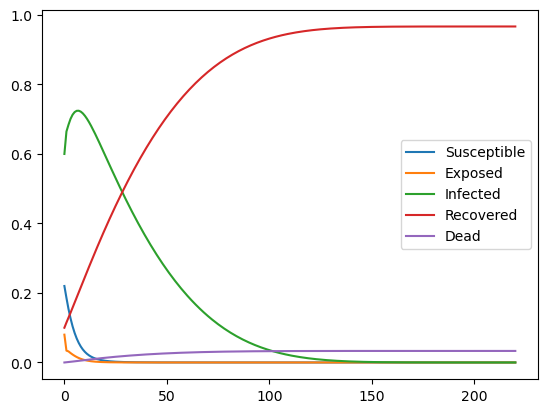

In [188]:
SEIR_=SEIR()
SEIR_.plot()